In [68]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('..')
from src.data import load_data

In [69]:
data_2020 = load_data("../data", "2020")
data_2019 = load_data("../data", "2019")

current_location = data_2020[:, 168, 150]
current_location_last_year = data_2020[:, 168, 150]

In [82]:
def compute_flow_rate_over_a_year(panel_size: int, point_data: np.array, panel_yield: float) -> np.array:
    """
    Compute the flow rate over a year for a given panel size.
    panel_size: the size of the panel in m².
    point_data: measures of irradiance for the given point in W/m² sampled every 15 minutes.
    panel_yield: the panel yield.
    returns: the flow rate corresponding to the given power.
    """
    assert panel_size >= 1.0, "Usually at least 3m² per pump are required"
    assert 0 < panel_yield < 1, "Panel yield must be between 0 and 1"

    panel_output_power = 1.0 * point_data * panel_size * panel_yield
    pump_entry_power = np.minimum(panel_output_power, 78.0)

    power_to_flow_rate_15_min = lambda power: max([(power - 74.5) / (4 * 0.00375), 0])
    return np.vectorize(power_to_flow_rate_15_min)(pump_entry_power)

In [83]:
compute_flow_rate_over_a_year(4, current_location, 0.15)

array([0, 0, 0, ..., 0, 0, 0])

In [107]:
from matplotlib.patches import Rectangle

# During the growth process we need a one to two month period with 4 times more water than the rest of the year.
# This period will define when we need to harvest plants
ROLLING_WINDOW = 60


def draw_rectangle(ax, minidx, maxidx, max_value, length):
    ax.add_patch(Rectangle((max([0, minidx]), 0), maxidx, max_value, color='green', alpha=0.2))

    if minidx <= 0:
        ax.add_patch(Rectangle((length + minidx, 0), -minidx, max_value, color='green', alpha=0.2))


def find_best_harvesting_period(yearly_flow_rate_15_min: np.array, last_year_flow_rate_15_min: np.array,
                                solar_surface: float = None) -> tuple[int, int]:
    """
    Returns the best harvesting period for a given flow rate of water sampled every 15 minutes.
    yearly_flow_rate_15_min: flow rate of water sampled every 15 minute
    last_year_flow_rate_15_min: flow rate of water sampled every 15 minute for the {window} days of last year
    returns: starting and ending index of the best period
    """
    daily_flow_rate = yearly_flow_rate_15_min.reshape((366, 96)).sum(axis=1)
    last_year_daily_flow_rate = last_year_flow_rate_15_min.reshape((ROLLING_WINDOW, 96)).sum(axis=1)

    # We need to smooth the curve because some days with a lot clouds are adding to much noise
    daily_flow_rate_series = pd.concat([pd.Series(last_year_daily_flow_rate), pd.Series(daily_flow_rate)])
    daily_flow_rate_trailing_7_days = daily_flow_rate_series.rolling(window=7, min_periods=0).mean()

    minimum_flow_trailing_60_days = daily_flow_rate_trailing_7_days.rolling(window=ROLLING_WINDOW).min()[
                                    ROLLING_WINDOW:]

    best_minimum_flow_rate_over_60_days = minimum_flow_trailing_60_days.max()

    # We have the max value now we need days index
    days_with_best_minimum_flow_rate_over_60_days = minimum_flow_trailing_60_days[
        minimum_flow_trailing_60_days >= 0.98 * best_minimum_flow_rate_over_60_days].index

    # As the minimum is computed over 60 previous days we subtract the time window
    period_start = days_with_best_minimum_flow_rate_over_60_days[0] - ROLLING_WINDOW
    period_end = days_with_best_minimum_flow_rate_over_60_days[-1]

    daily_flow_rate_trailing_7_days = daily_flow_rate_trailing_7_days[ROLLING_WINDOW:]

    length = len(minimum_flow_trailing_60_days)

    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    fig.suptitle(
        f"Smoothed daily flow (L/days) with targeted harvesting period \n Solar panel surface area: {solar_surface}m²")
    sns.lineplot(x=range(len(daily_flow_rate_trailing_7_days)), ax=ax, y=daily_flow_rate_trailing_7_days)
    draw_rectangle(ax, period_start, period_end, best_minimum_flow_rate_over_60_days, length)
    ax.axhline(y=best_minimum_flow_rate_over_60_days, color='g')
    ax.axhline(y=0, color='k')

    if solar_surface is not None:
        plt.savefig(f"../docs/daily_flow{solar_surface:.0f}m2.png")
    else:
        plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    fig.suptitle(
        f"Minimum daily flow trailing 60 days (L/days) with targeted harvesting period \n Solar panel surface area: {solar_surface}m²")
    sns.lineplot(x=range(len(minimum_flow_trailing_60_days)), ax=ax, y=minimum_flow_trailing_60_days)
    draw_rectangle(ax, period_start, period_end, best_minimum_flow_rate_over_60_days, length)
    ax.axhline(y=best_minimum_flow_rate_over_60_days, color='g')
    ax.axhline(y=0, color='k')
    plt.show()

    return period_start, period_end


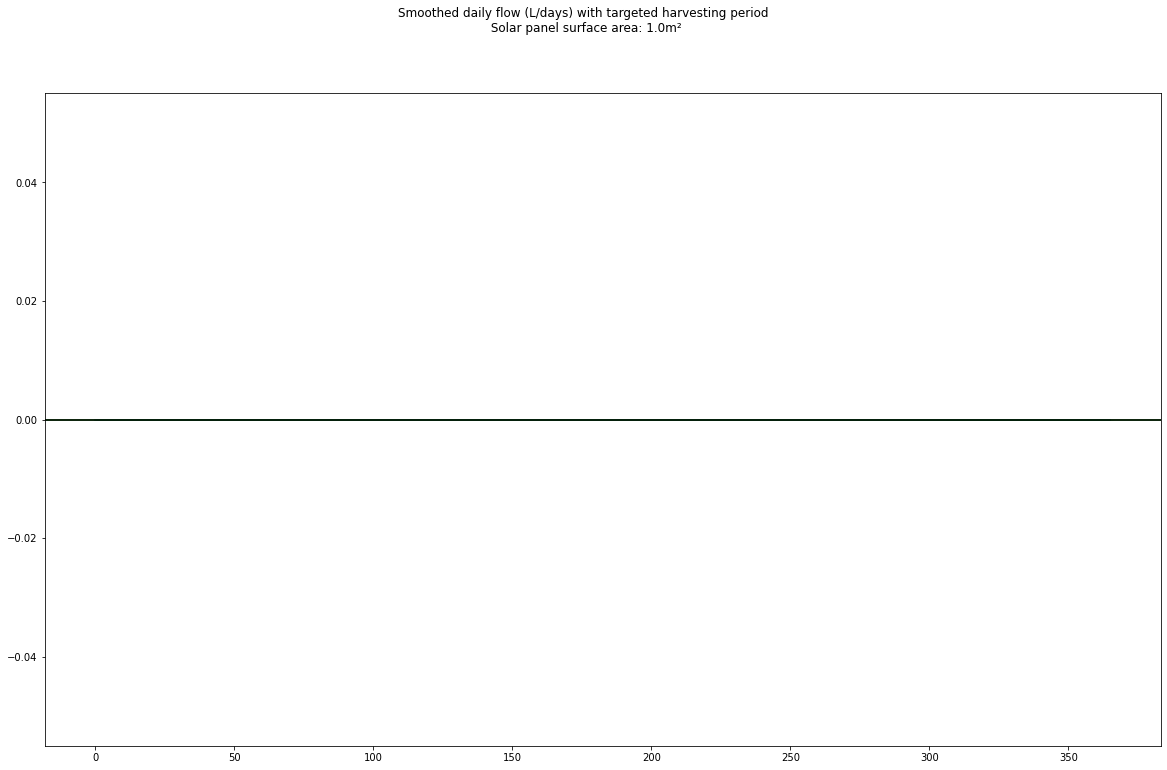

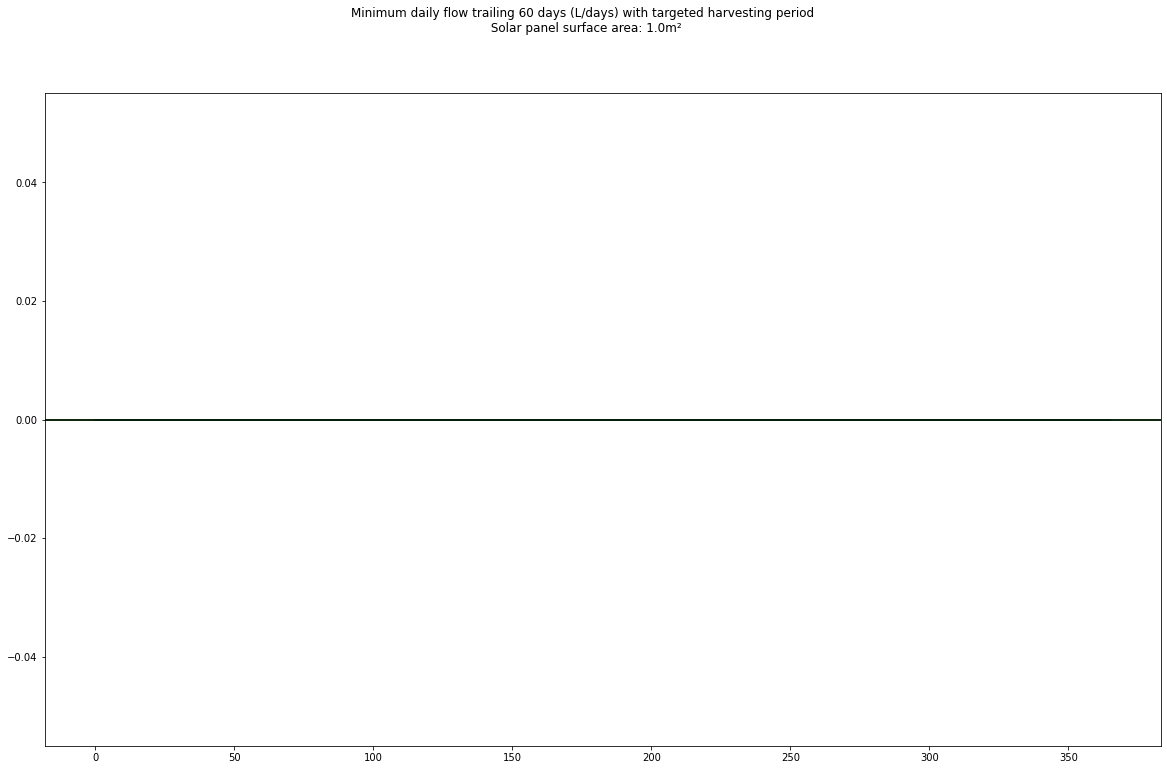

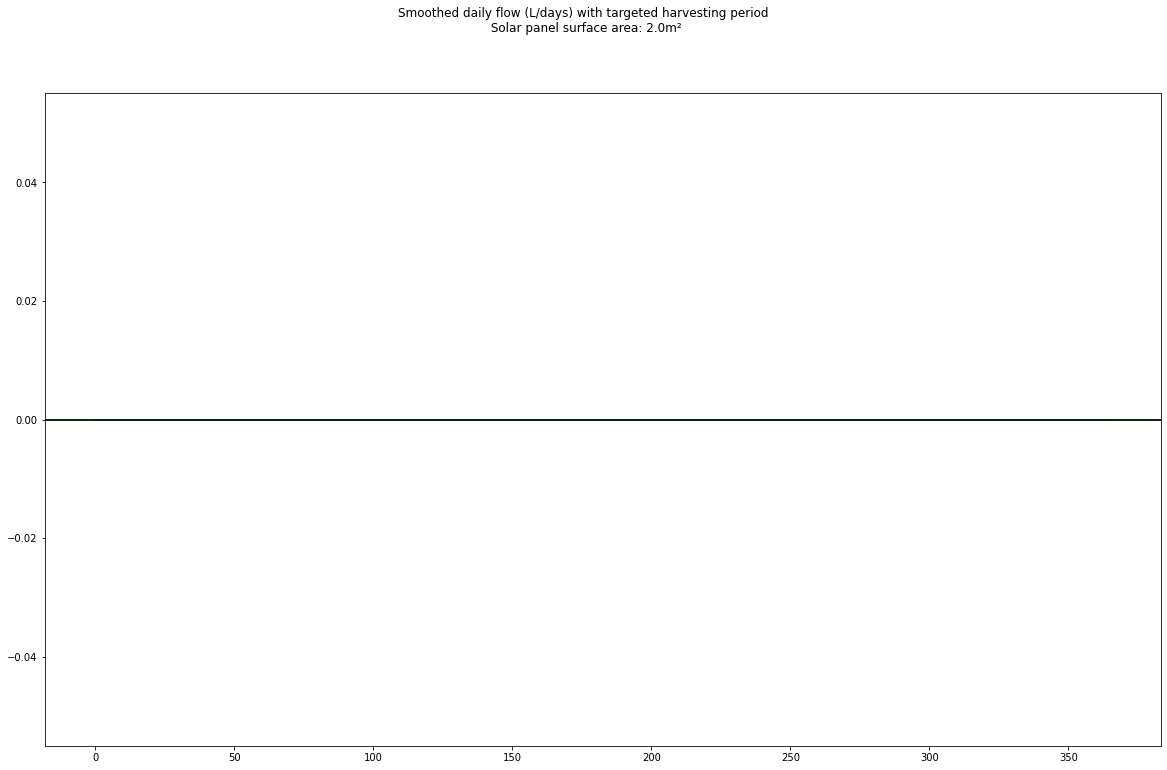

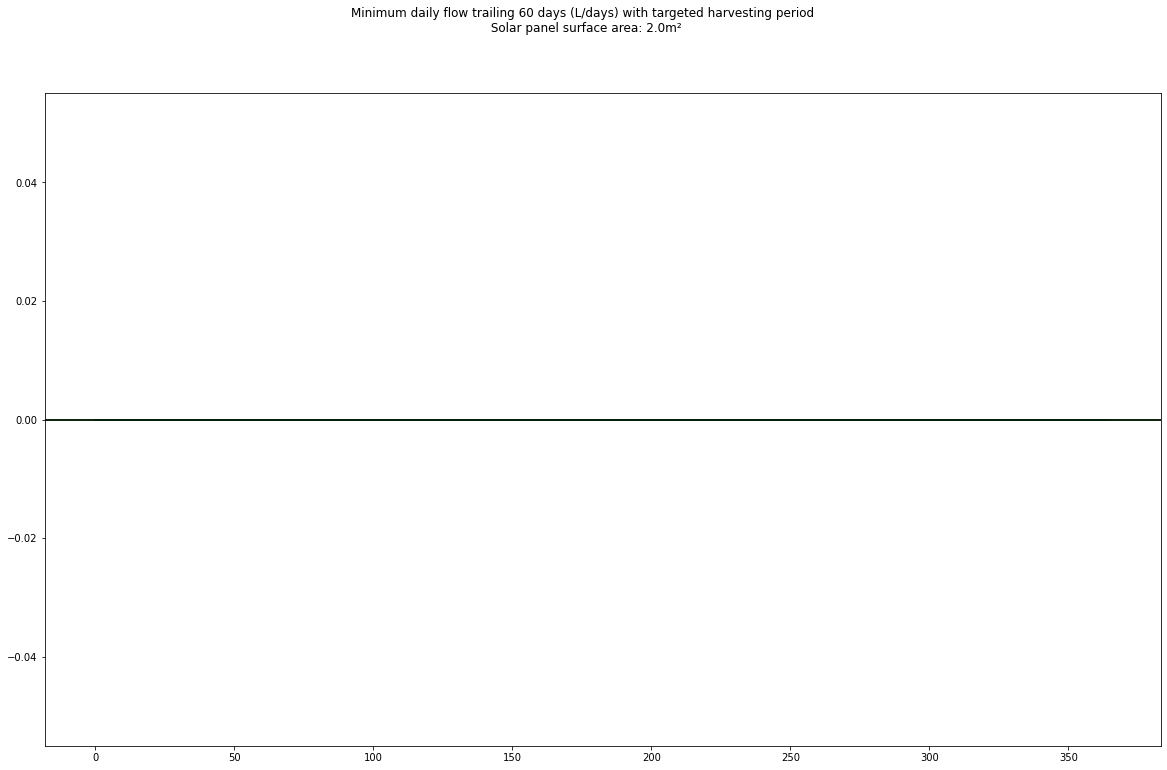

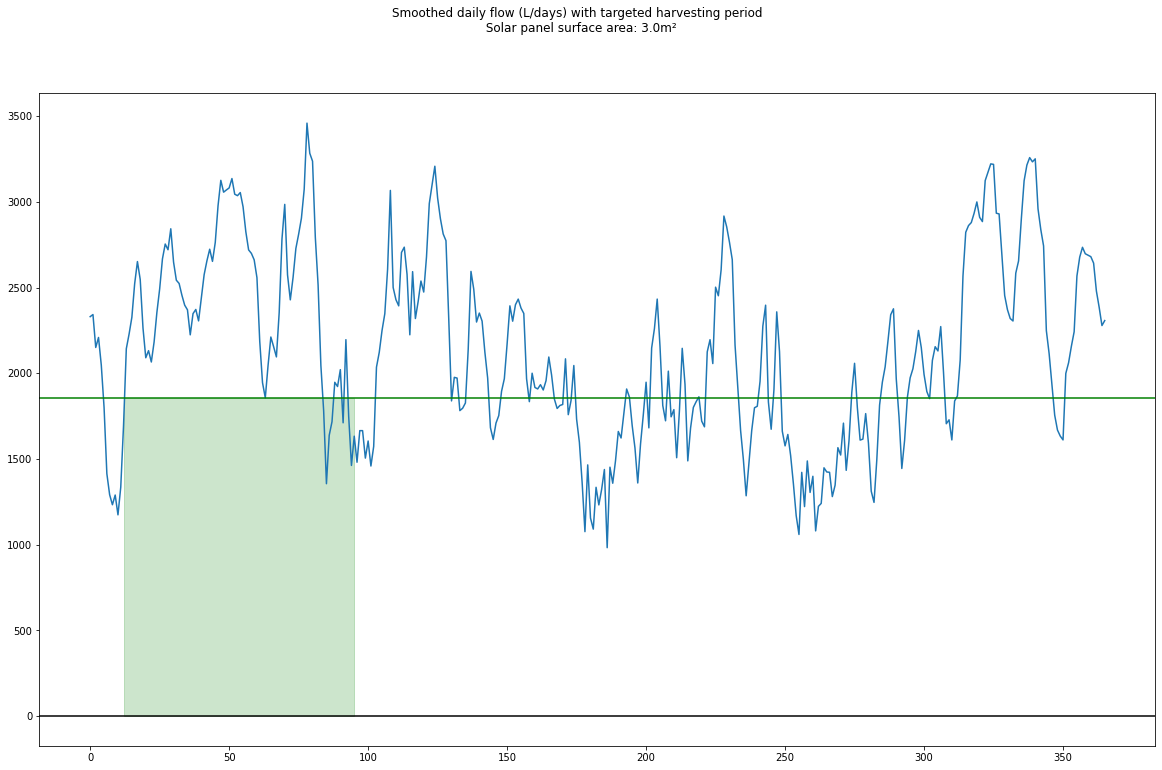

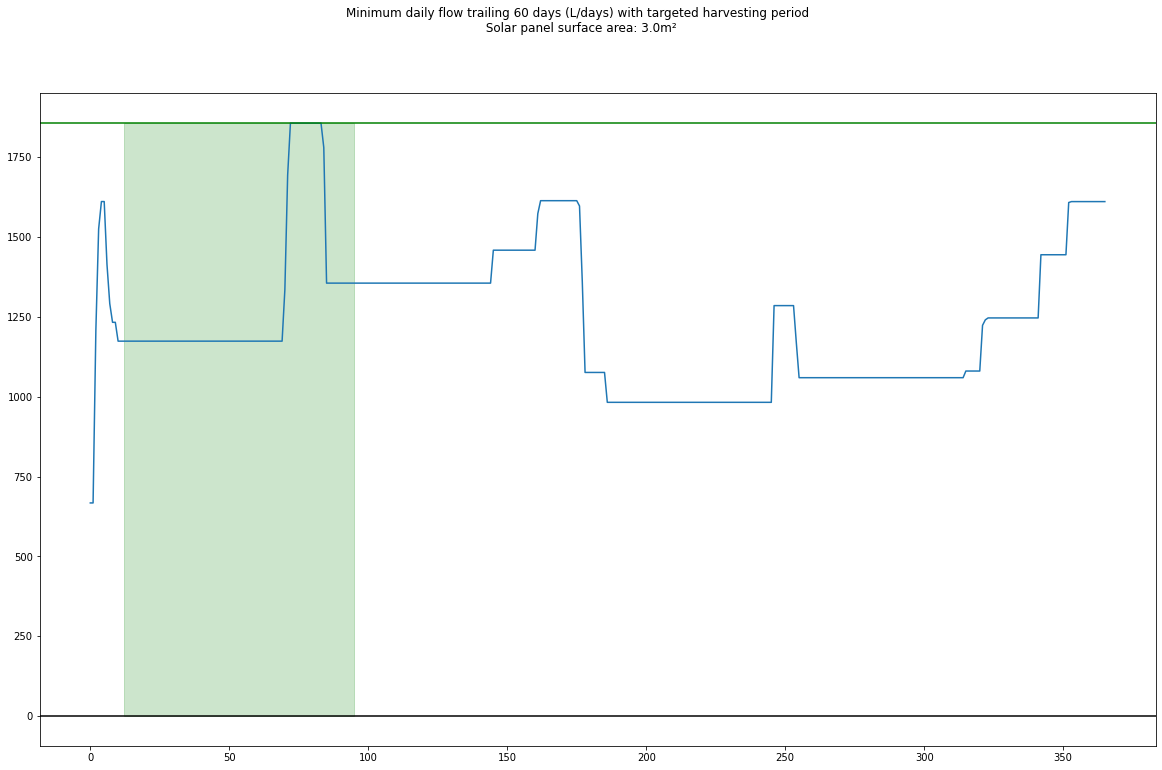

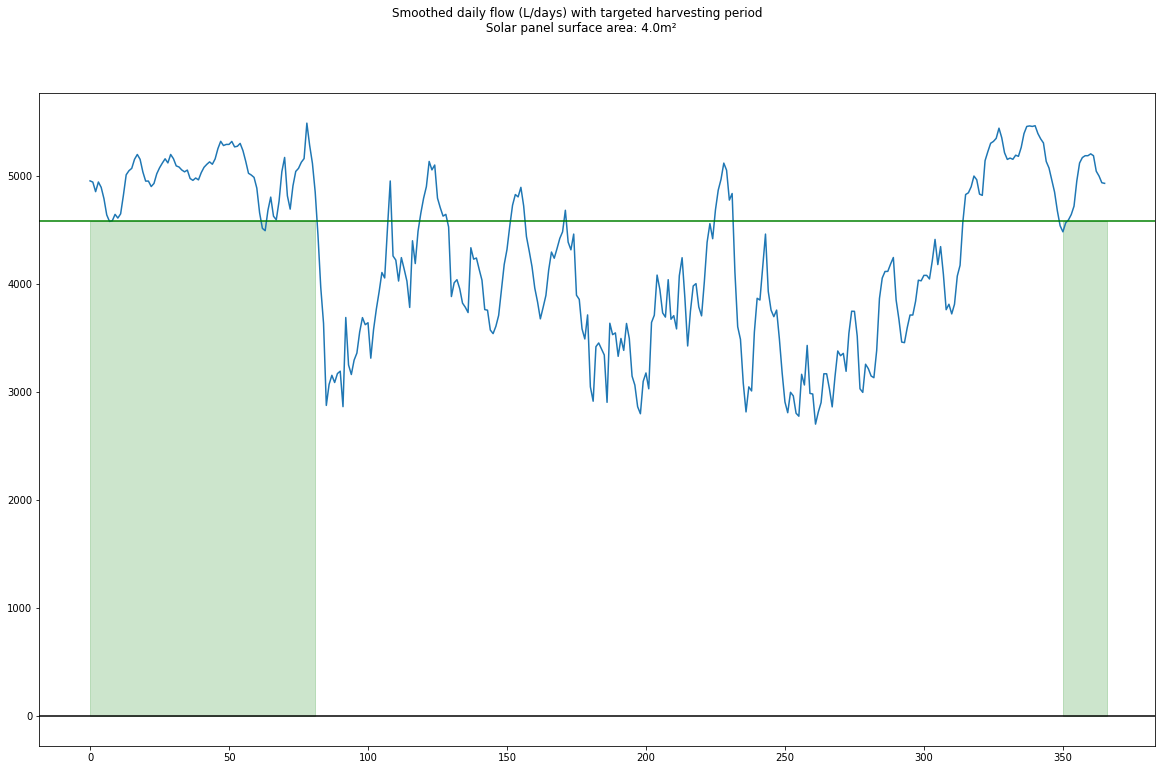

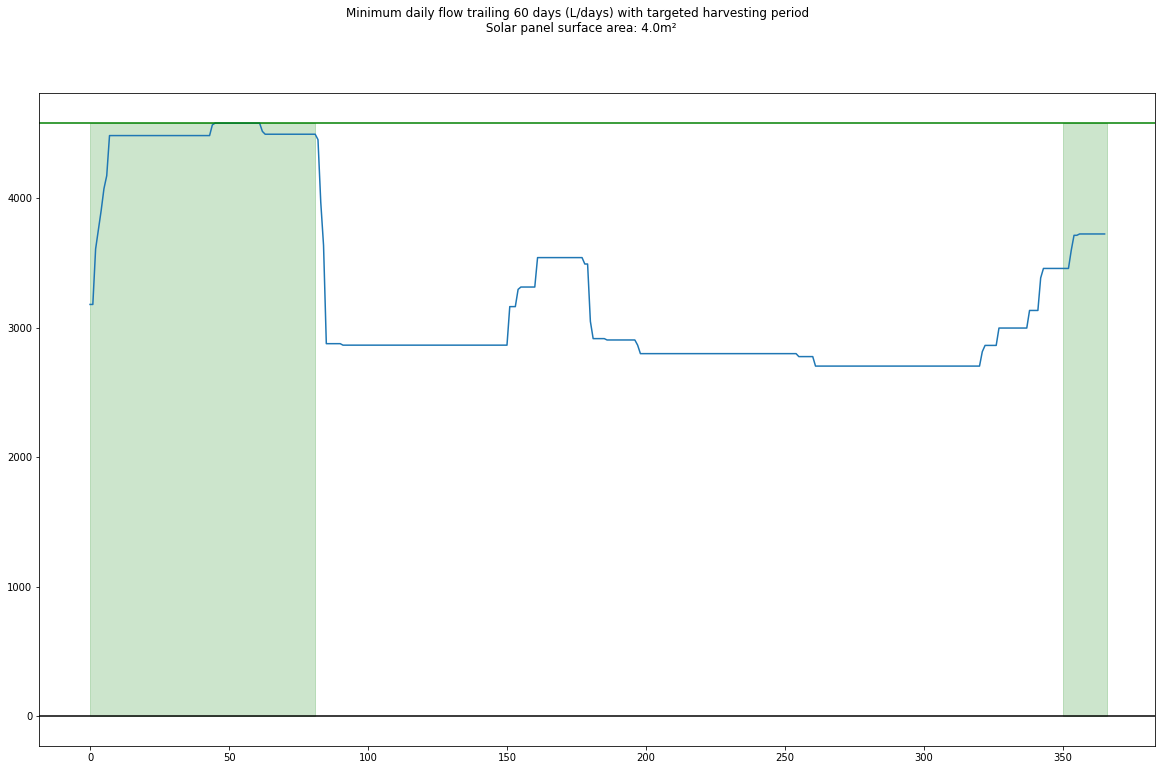

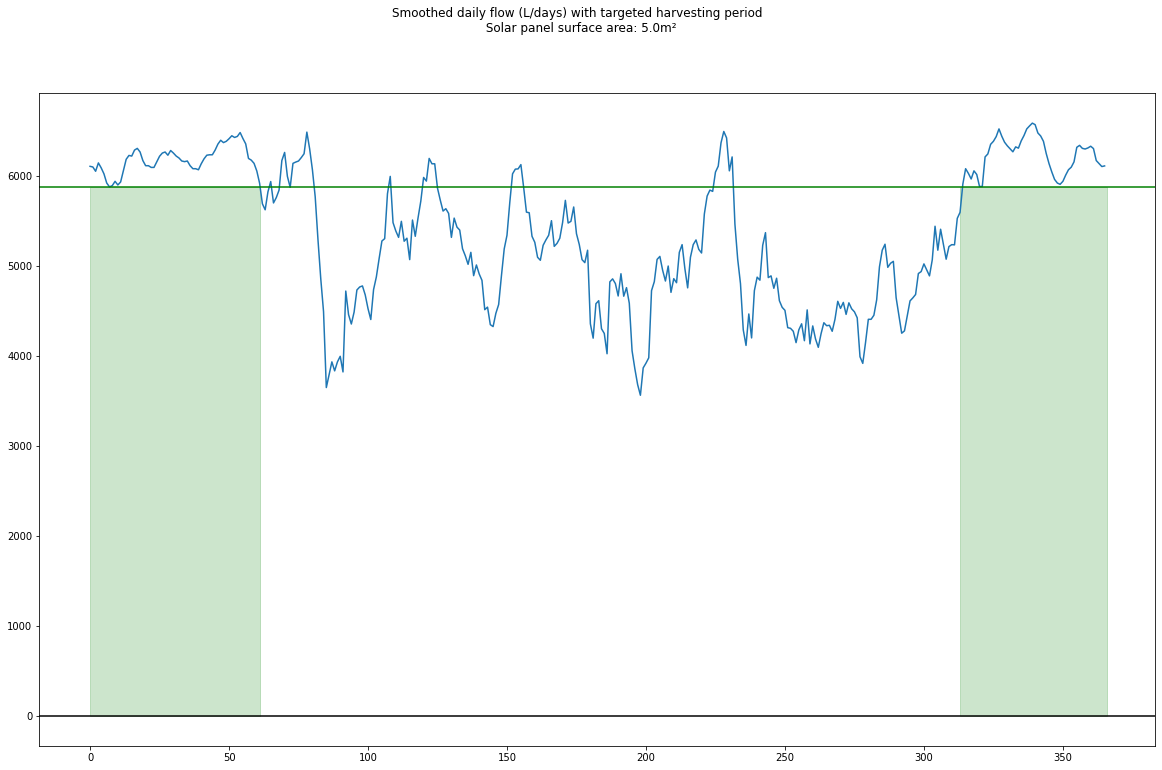

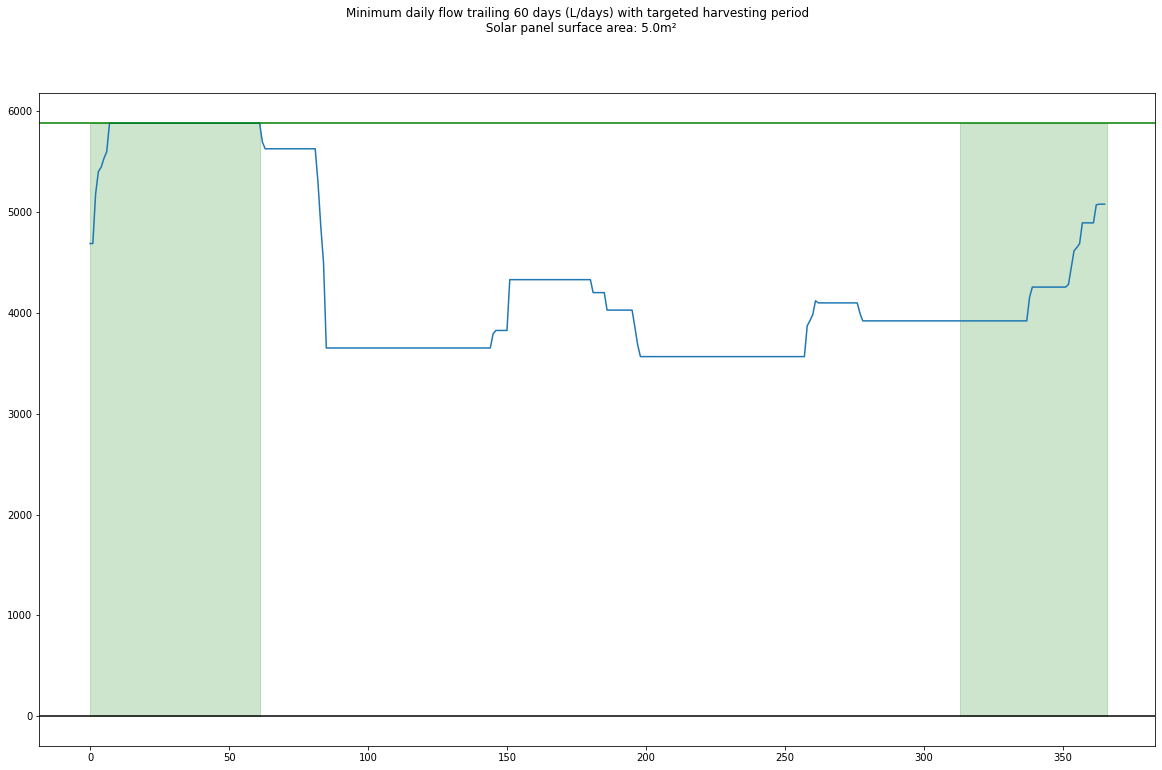

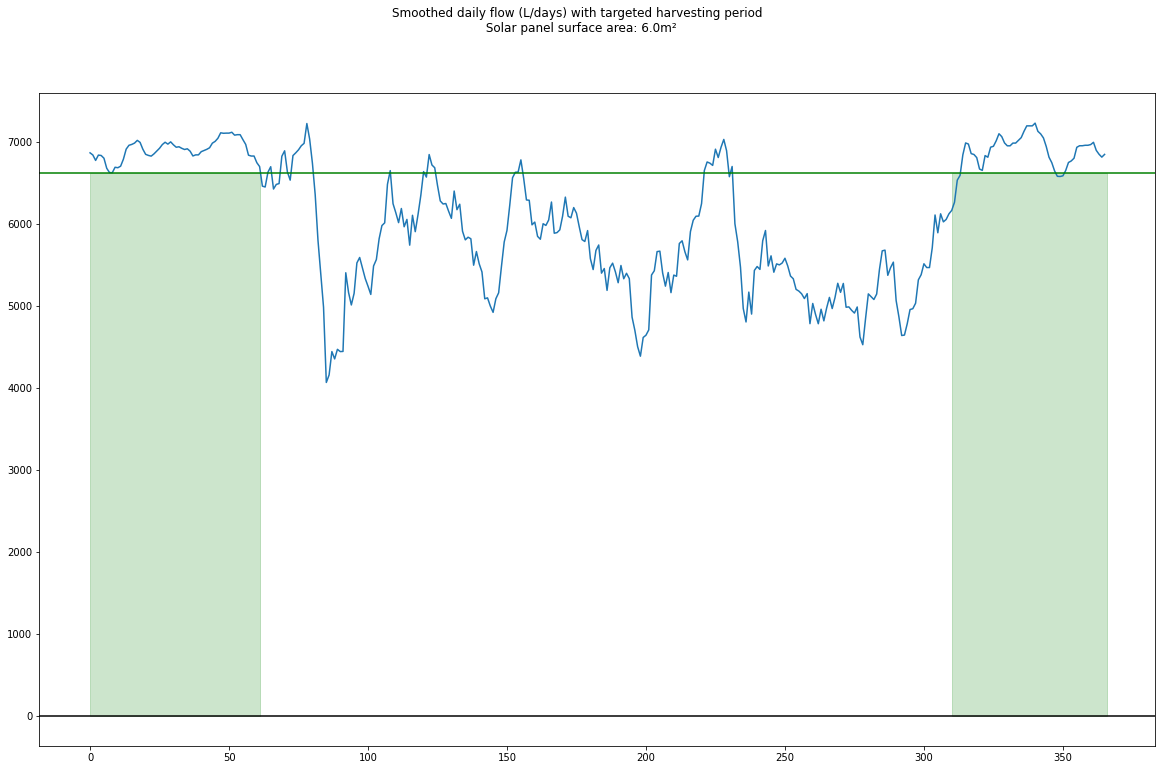

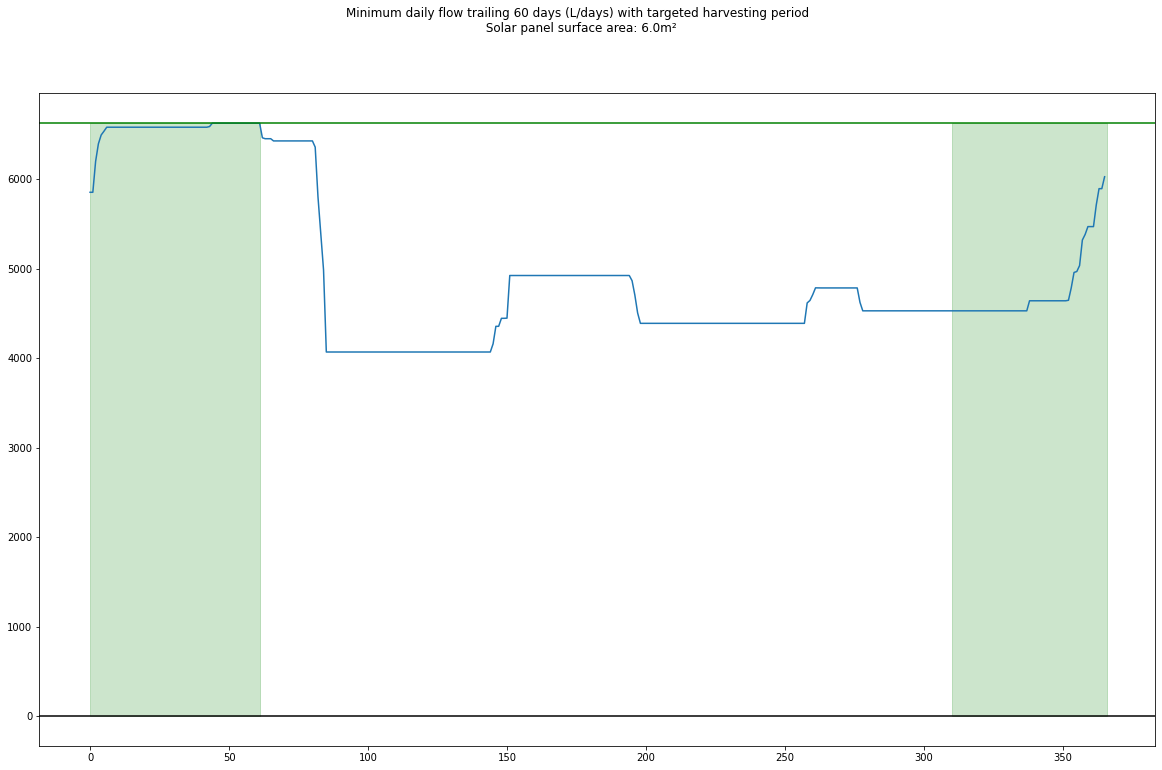

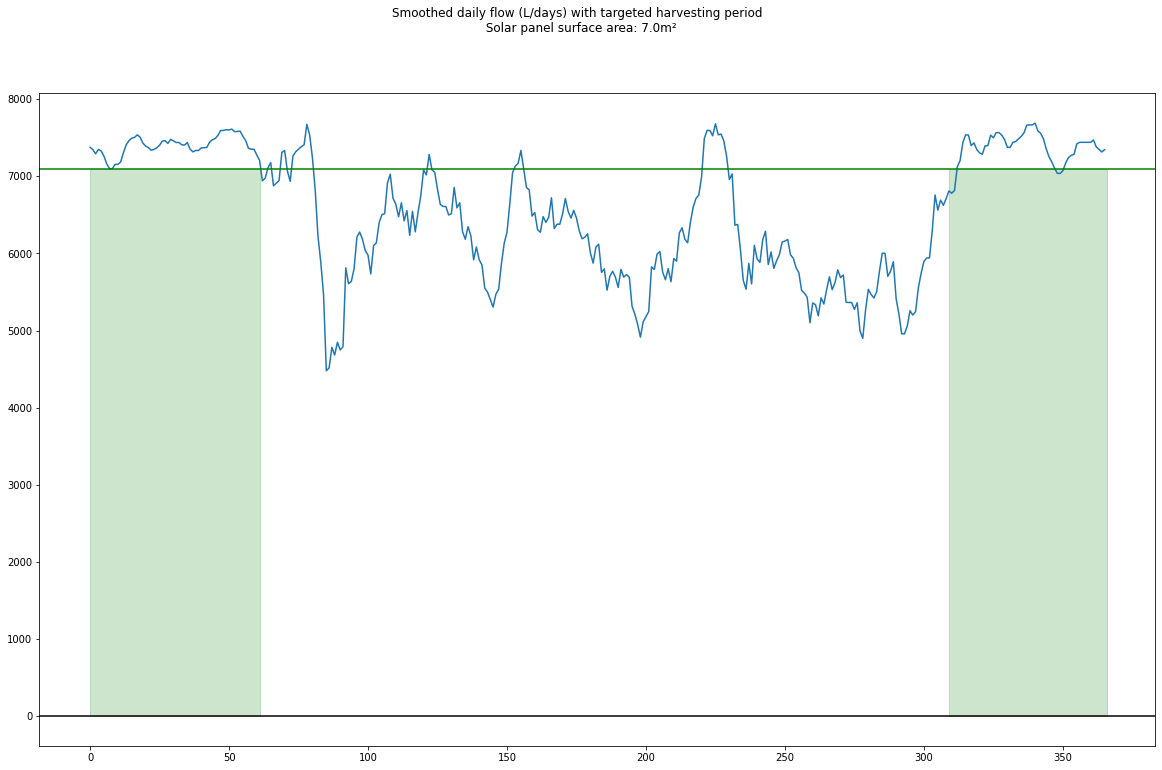

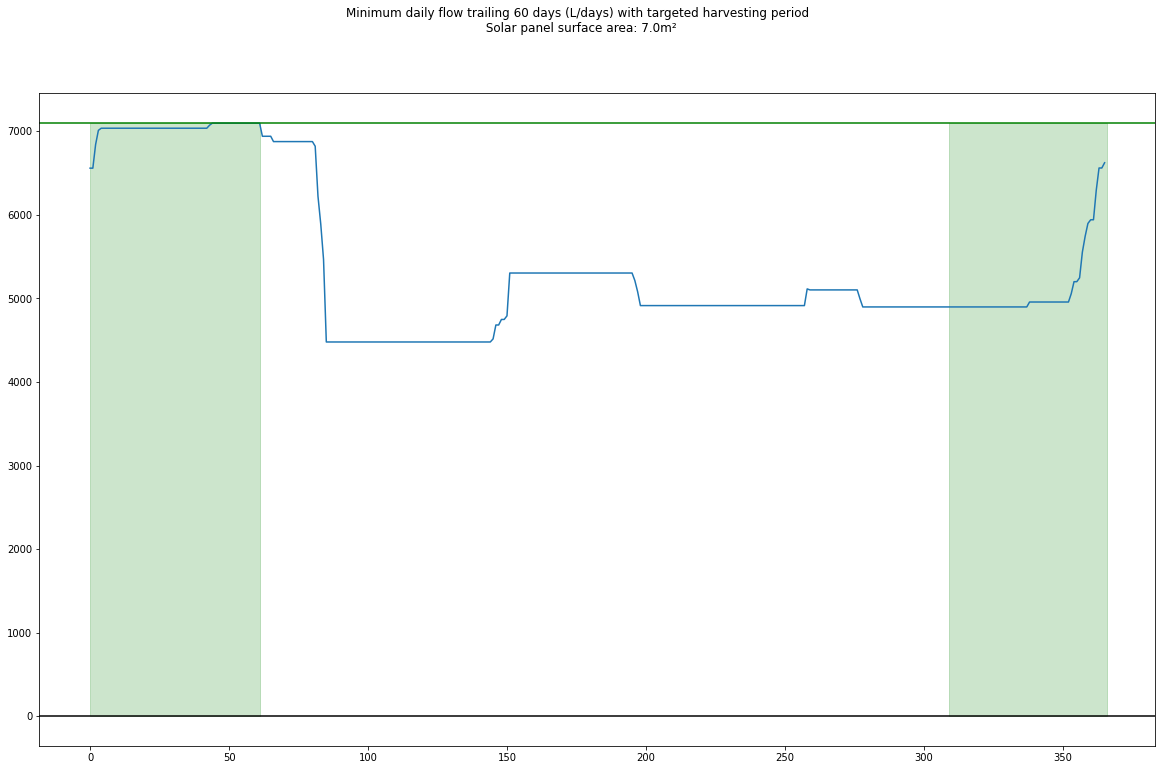

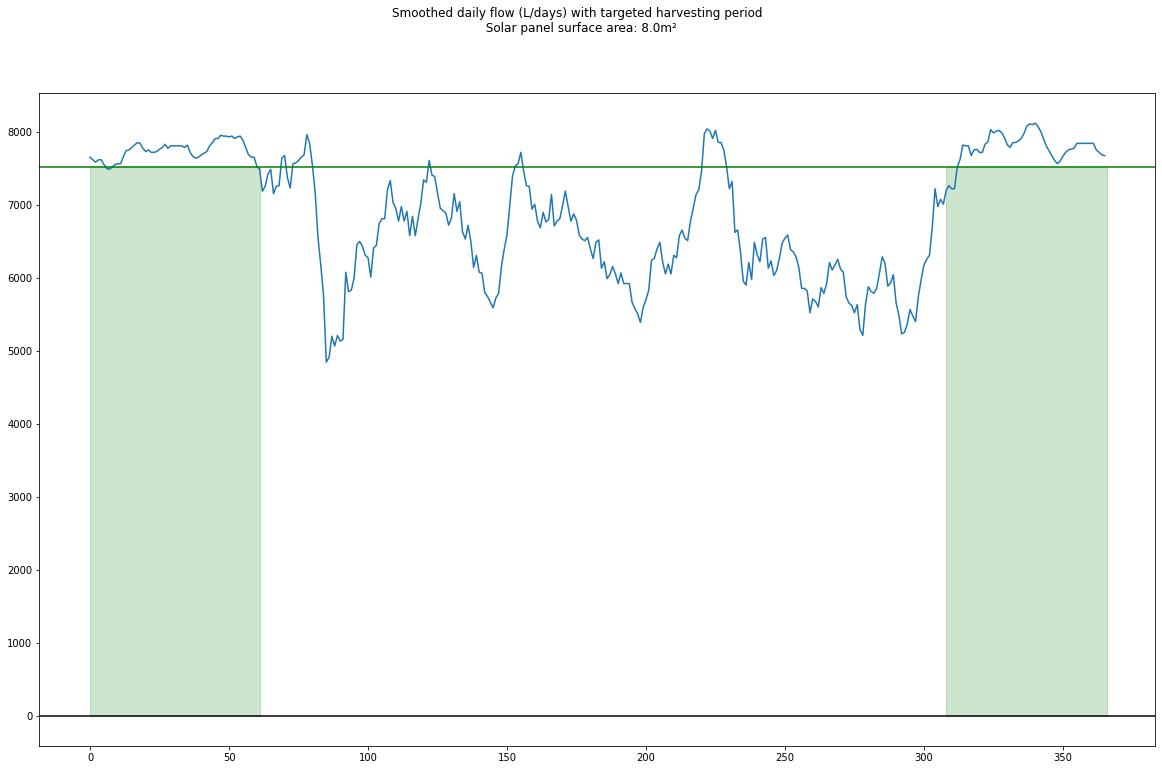

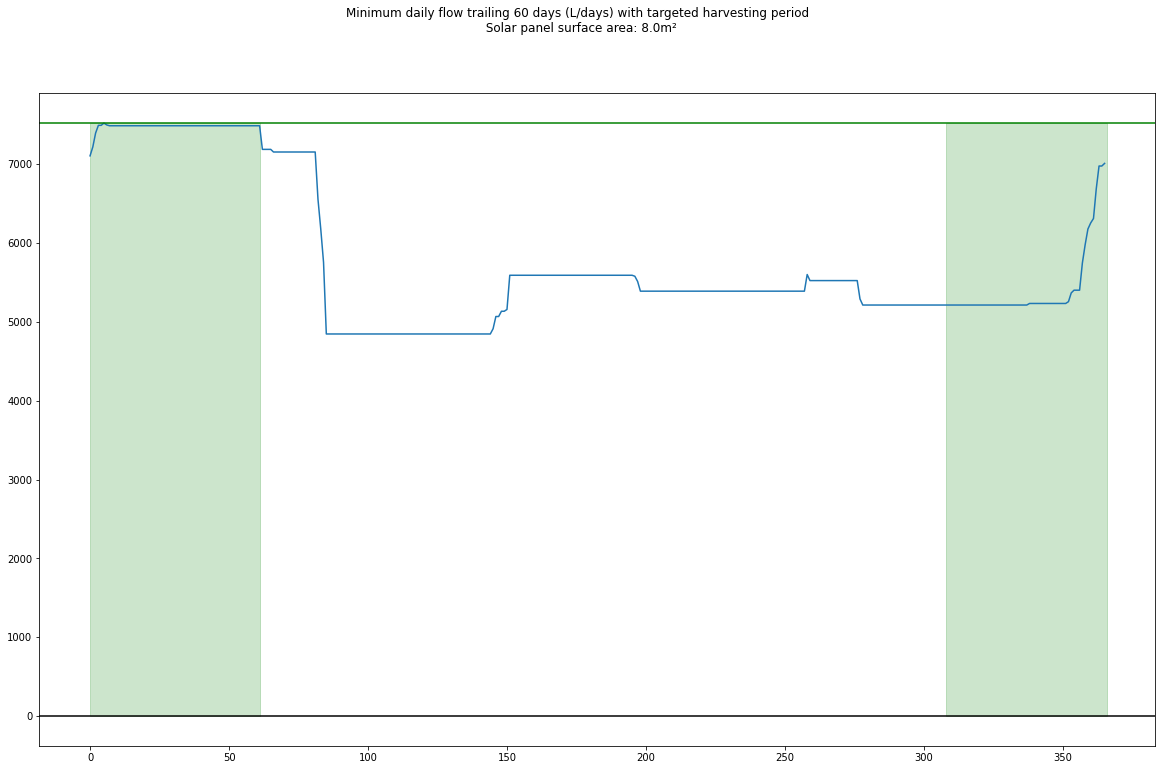

In [108]:
for solar_surface in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]:
    current_year_data = compute_flow_rate_over_a_year(solar_surface, current_location, 0.15)
    last_year_last_60_days = compute_flow_rate_over_a_year(solar_surface, current_location_last_year, 0.15)[-60 * 96:]
    find_best_harvesting_period(current_year_data, last_year_last_60_days, solar_surface)